# Análise exploratória de dados do E-commerce Olist

- Os dados foram extraídos do Kaggle via API
- Foram carregados em um arquivo de banco de dados SQLite utilizando a biblioteca sqlite3
- Foram feitas queries SQL respondendo a algumas perguntas gerais
- Foram feitas inspeções e transformação dos dados
- Foi feita uma análise espacial com o geopandas e uma análise dos comentários de avaliação dos clientes

## Importando bibliotecas

In [1]:
import pandas as pd
import numpy as np

import sqlite3
from IPython.display import Image

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import squarify
import geopandas as gpd

## Importando os dados do Kaggle via API

> ETL (extract): processo de extração dos dados do Kaggle.

In [2]:
#!kaggle datasets download -d olistbr/brazilian-ecommerce

In [3]:
olist_customers = pd.read_csv('brazilian-ecommerce/olist_customers_dataset.csv', index_col=0)
olist_geolocation = pd.read_csv('brazilian-ecommerce/olist_geolocation_dataset.csv', index_col=0)
olist_order_items = pd.read_csv('brazilian-ecommerce/olist_order_items_dataset.csv', index_col=0)
olist_order_payments = pd.read_csv('brazilian-ecommerce/olist_order_payments_dataset.csv', index_col=0)
olist_order_reviews = pd.read_csv('brazilian-ecommerce/olist_order_reviews_dataset.csv', index_col=0)
olist_orders = pd.read_csv('brazilian-ecommerce/olist_orders_dataset.csv', index_col=0)
olist_products = pd.read_csv('brazilian-ecommerce/olist_products_dataset.csv', index_col=0)
olist_sellers = pd.read_csv('brazilian-ecommerce/olist_sellers_dataset.csv', index_col=0)
product_category_name = pd.read_csv('brazilian-ecommerce/product_category_name_translation.csv', index_col=0)

## Inspecionando os dados

In [4]:
dfs = {
    'olist_customers': olist_customers,
    'olist_geolocation': olist_geolocation,
    'olist_order_items': olist_order_items,
    'olist_order_payments': olist_order_payments,
    'olist_order_reviews': olist_order_reviews,
    'olist_orders': olist_orders,
    'olist_products': olist_products,
    'olist_sellers': olist_sellers,
    'product_category_name': product_category_name
}

Checando as dimensões dos dados.

In [5]:
for name, df in dfs.items():
    print(f'{name}: {df.shape}')

olist_customers: (99441, 4)
olist_geolocation: (1000163, 4)
olist_order_items: (112650, 6)
olist_order_payments: (103886, 4)
olist_order_reviews: (99224, 6)
olist_orders: (99441, 7)
olist_products: (32951, 8)
olist_sellers: (3095, 3)
product_category_name: (71, 1)


### Checando dados nulos

In [6]:
def count_nulls(column):
    return column.isna().sum()

In [7]:
for df_name, df in dfs.items():
    null_counts = df.isnull().sum()
    print(f'tabela: {df_name}')
    print('-' * 50)
    print(null_counts)
    print('-' * 50)

tabela: olist_customers
--------------------------------------------------
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64
--------------------------------------------------
tabela: olist_geolocation
--------------------------------------------------
geolocation_lat      0
geolocation_lng      0
geolocation_city     0
geolocation_state    0
dtype: int64
--------------------------------------------------
tabela: olist_order_items
--------------------------------------------------
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64
--------------------------------------------------
tabela: olist_order_payments
--------------------------------------------------
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64
--------------------

**Há dados faltantes nas tabelas:** 

- **olist_order_reviews**:
    - review_comment_title
    - review_comment_message  

Por serem quase sempre opcionais, pode ser considerado normal que haja dados faltantes nos títulos e comentários de avaliações de produtos. 

- **olist_orders:**

    - order_approved_at
    - order_delivered_carrier_date
    - order_delivered_customer_date  
    
Os dados acima são temporais e importantes informações sobre pedidos. O status do pedido parece estar atrelado aos dados faltantes.


- **olist_products:**

    - product_category_name
    - product_name_lenght
    - product_description_lenght
    - product_photos_qty
    
    
Os dados realmente ou não foram informados pelos vendedores ou há algum problema para processá-los.

In [8]:
# Checando a possibilidade de os dados ausentes estarem atrelados ao status do pedido

olist_orders['order_status'].value_counts()

order_status
delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: count, dtype: int64

- Os status **"canceled"** (cancelado), **"unavailable"** (indisponível), **"processing"** (em processamento), **"criated"** (criado) e **"approved"** (aprovado) podem estar atrelados aos dados faltantes nas colunas de data de aprovação do pedido (``order_approved_at``), data de entrega para o transportador (``order_delivered_carrier_date``) e data de entrega ao cliente (``order_delivered_customer_date``), pois são colunas relacionadas às etapas transacionais de fechamento do pedido, sendo assim, pedidos que estão em aberto ou não concluídos, não terão os dados das respectivas colunas. Quando um pedido é cancelado ou considerado indisponível, essas datas podem também não ser relevantes, uma vez que o pedido não será mais processado.

- Abaixo é possível ver que os pedidos **"shipped"** (enviados) estão com dados faltantes na coluna ``order_delivered_customer_date``(data de entrega ao cliente), algo que faz sentido, pois os pedidos foram apenas enviados.

In [9]:
olist_orders[olist_orders['order_status'] == "shipped"].isna().sum()

customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                   0
order_delivered_carrier_date        0
order_delivered_customer_date    1107
order_estimated_delivery_date       0
dtype: int64

- O mesmo pode ser dito dos pedidos **"canceled"** (cancelados), pois há dados faltantes nas colunas **"order_approved_at"** (horário de aprovação do pedido), **"order_delivered_carrier_date"** (horário de entrega ao transportador), **"order_delivered_customer_date"** (horário de entrega ao cliente) e **"order_estimated_delivery_date"** (horário estimado de entrega).

In [10]:
olist_orders[olist_orders['order_status'] == "canceled"].isna().sum()

customer_id                        0
order_status                       0
order_purchase_timestamp           0
order_approved_at                141
order_delivered_carrier_date     550
order_delivered_customer_date    619
order_estimated_delivery_date      0
dtype: int64

In [11]:
# Checando os dados faltantes da coluna de categoria

olist_products[olist_products['product_category_name'].isna()]

,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
product_id,,,,,,,,
a41e356c76fab66334f36de622ecbd3a,NaN,NaN,NaN,NaN,650.0,17.0,14.0,12.0
d8dee61c2034d6d075997acef1870e9b,NaN,NaN,NaN,NaN,300.0,16.0,7.0,20.0
56139431d72cd51f19eb9f7dae4d1617,NaN,NaN,NaN,NaN,200.0,20.0,20.0,20.0
46b48281eb6d663ced748f324108c733,NaN,NaN,NaN,NaN,18500.0,41.0,30.0,41.0
5fb61f482620cb672f5e586bb132eae9,NaN,NaN,NaN,NaN,300.0,35.0,7.0,12.0
...,...,...,...,...,...,...,...,...
b0a0c5dd78e644373b199380612c350a,NaN,NaN,NaN,NaN,1800.0,30.0,20.0,70.0
10dbe0fbaa2c505123c17fdc34a63c56,NaN,NaN,NaN,NaN,800.0,30.0,10.0,23.0
bd2ada37b58ae94cc838b9c0569fecd8,NaN,NaN,NaN,NaN,200.0,21.0,8.0,16.0


- Os dados acima parecem não ser obrigatórios na plataforma. Nesse caso, pode sugerir que essas informações não foram obrigatoriamente fornecidas pelos vendedores na plataforma ou que há algum problema para processar esses dados. Para confirmar essa suposição e chegar a uma conclusão definitiva, seria necessário realizar uma investigação mais aprofundada sobre os processos de entrada de dados na plataforma.

### Checando os tipos de dados

In [12]:
for df_name, df in dfs.items():
    print(f'Tabela: {df_name}')
    print('-' * 50)
    print(f'Tipos de Dados da tabela {df_name}:')
    print(df.dtypes)
    print('-' * 50)

Tabela: olist_customers
--------------------------------------------------
Tipos de Dados da tabela olist_customers:
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object
--------------------------------------------------
Tabela: olist_geolocation
--------------------------------------------------
Tipos de Dados da tabela olist_geolocation:
geolocation_lat      float64
geolocation_lng      float64
geolocation_city      object
geolocation_state     object
dtype: object
--------------------------------------------------
Tabela: olist_order_items
--------------------------------------------------
Tipos de Dados da tabela olist_order_items:
order_item_id            int64
product_id              object
seller_id               object
shipping_limit_date     object
price                  float64
freight_value          float64
dtype: object
--------------------------------------------------
Tabe

## Transformação dos dados

> ETL (transform): etapa de transformação dos dados.

###### olist_order_reviews

Transformando `review_creation_date` e `review_answer_timestamp` de object para datetime.

In [13]:
olist_order_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99224 entries, 7bc2406110b926393aa56f80a40eba40 to efe49f1d6f951dd88b51e6ccd4cc548f
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   order_id                 99224 non-null  object
 1   review_score             99224 non-null  int64 
 2   review_comment_title     11568 non-null  object
 3   review_comment_message   40977 non-null  object
 4   review_creation_date     99224 non-null  object
 5   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(5)
memory usage: 5.3+ MB


In [14]:
olist_order_reviews['review_creation_date'] = pd.to_datetime(olist_order_reviews['review_creation_date'])

olist_order_reviews['review_answer_timestamp'] = pd.to_datetime(olist_order_reviews['review_answer_timestamp'])

print(olist_order_reviews.info())

<class 'pandas.core.frame.DataFrame'>
Index: 99224 entries, 7bc2406110b926393aa56f80a40eba40 to efe49f1d6f951dd88b51e6ccd4cc548f
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   order_id                 99224 non-null  object        
 1   review_score             99224 non-null  int64         
 2   review_comment_title     11568 non-null  object        
 3   review_comment_message   40977 non-null  object        
 4   review_creation_date     99224 non-null  datetime64[ns]
 5   review_answer_timestamp  99224 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 5.3+ MB
None


###### olist_geolocation

Foi necessário remover a acentuação dos nomes das cidades, pois algumas delas apresentavam dados duplicados em decorrência da presença do nome com e sem acento, por exemplo: "são paulo" e "sao paulo".

In [15]:
olist_geolocation['geolocation_city'].value_counts()

geolocation_city
sao paulo               135800
rio de janeiro           62151
belo horizonte           27805
são paulo                24918
curitiba                 16593
                         ...  
jacuípe                      1
mar vermelho                 1
quebrangulo                  1
poço das trincheiras         1
poxim                        1
Name: count, Length: 8011, dtype: int64

In [16]:
# Checando a cidade de São Paulo sem acento
olist_geolocation[olist_geolocation['geolocation_city'] == "sao paulo"]["geolocation_city"]

geolocation_zip_code_prefix
1037    sao paulo
1046    sao paulo
1046    sao paulo
1041    sao paulo
1035    sao paulo
          ...    
8450    sao paulo
8473    sao paulo
8411    sao paulo
8470    sao paulo
9540    sao paulo
Name: geolocation_city, Length: 135800, dtype: object

In [17]:
# Checando a cidade de São Paulo sem acento
olist_geolocation[olist_geolocation['geolocation_city'] == "são paulo"]["geolocation_city"]

geolocation_zip_code_prefix
1012     são paulo
1037     são paulo
1024     são paulo
1020     são paulo
1011     são paulo
           ...    
8451     são paulo
8430     são paulo
8465     são paulo
8543     são paulo
18271    são paulo
Name: geolocation_city, Length: 24918, dtype: object

In [18]:
olist_geolocation['geolocation_city'] = olist_geolocation['geolocation_city'].str.normalize(
    'NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8').str.lower()

In [19]:
olist_geolocation['geolocation_city'].value_counts()

geolocation_city
sao paulo                160719
rio de janeiro            62151
belo horizonte            27805
curitiba                  16593
porto alegre              13521
                          ...  
poxim                         1
luziapolis                    1
sao jose dos salgados         1
martins guimaraes             1
lagoa salgada                 1
Name: count, Length: 5968, dtype: int64

Percebe-se que o número da cidade subiu de 135800 para 160719. As outras cidades com acentuação também tiveram esse problema resolvido.

## Criando o banco de dados

> ETL - load: Etapa de carregamento com a criação do banco de dados.

Conexão do banco de dados.

In [20]:
conn = sqlite3.connect('olist.db')

In [21]:
cursor = conn.cursor()

Criando as tabelas do banco de dados.

In [22]:
olist_customers.to_sql(name='olist_customers', con=conn, if_exists='replace')
olist_geolocation.to_sql(name='olist_geolocation', con=conn, if_exists='replace')
olist_order_items.to_sql(name='olist_order_items',con=conn, if_exists='replace')
olist_order_payments.to_sql(name='olist_order_payments', con=conn, if_exists='replace')
olist_order_reviews.to_sql(name='olist_order_reviews', con=conn, if_exists='replace')
olist_orders.to_sql(name='olist_orders', con=conn, if_exists='replace')
olist_products.to_sql(name='olist_products', con=conn, if_exists='replace')
olist_sellers.to_sql(name='olist_sellers', con=conn, if_exists='replace')
#product_category_name.to_sql(name='product_category_name', con=conn, if_exists='replace')

3095

Checando as tabelas presentes no banco de dados.

In [23]:
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")

In [24]:
tables = cursor.fetchall()
for table in tables:
    print(table[0])

olist_customers
olist_geolocation
olist_order_items
olist_order_payments
olist_order_reviews
olist_orders
olist_products
olist_sellers


## MER (Modelo Entidade-Relacionamento)

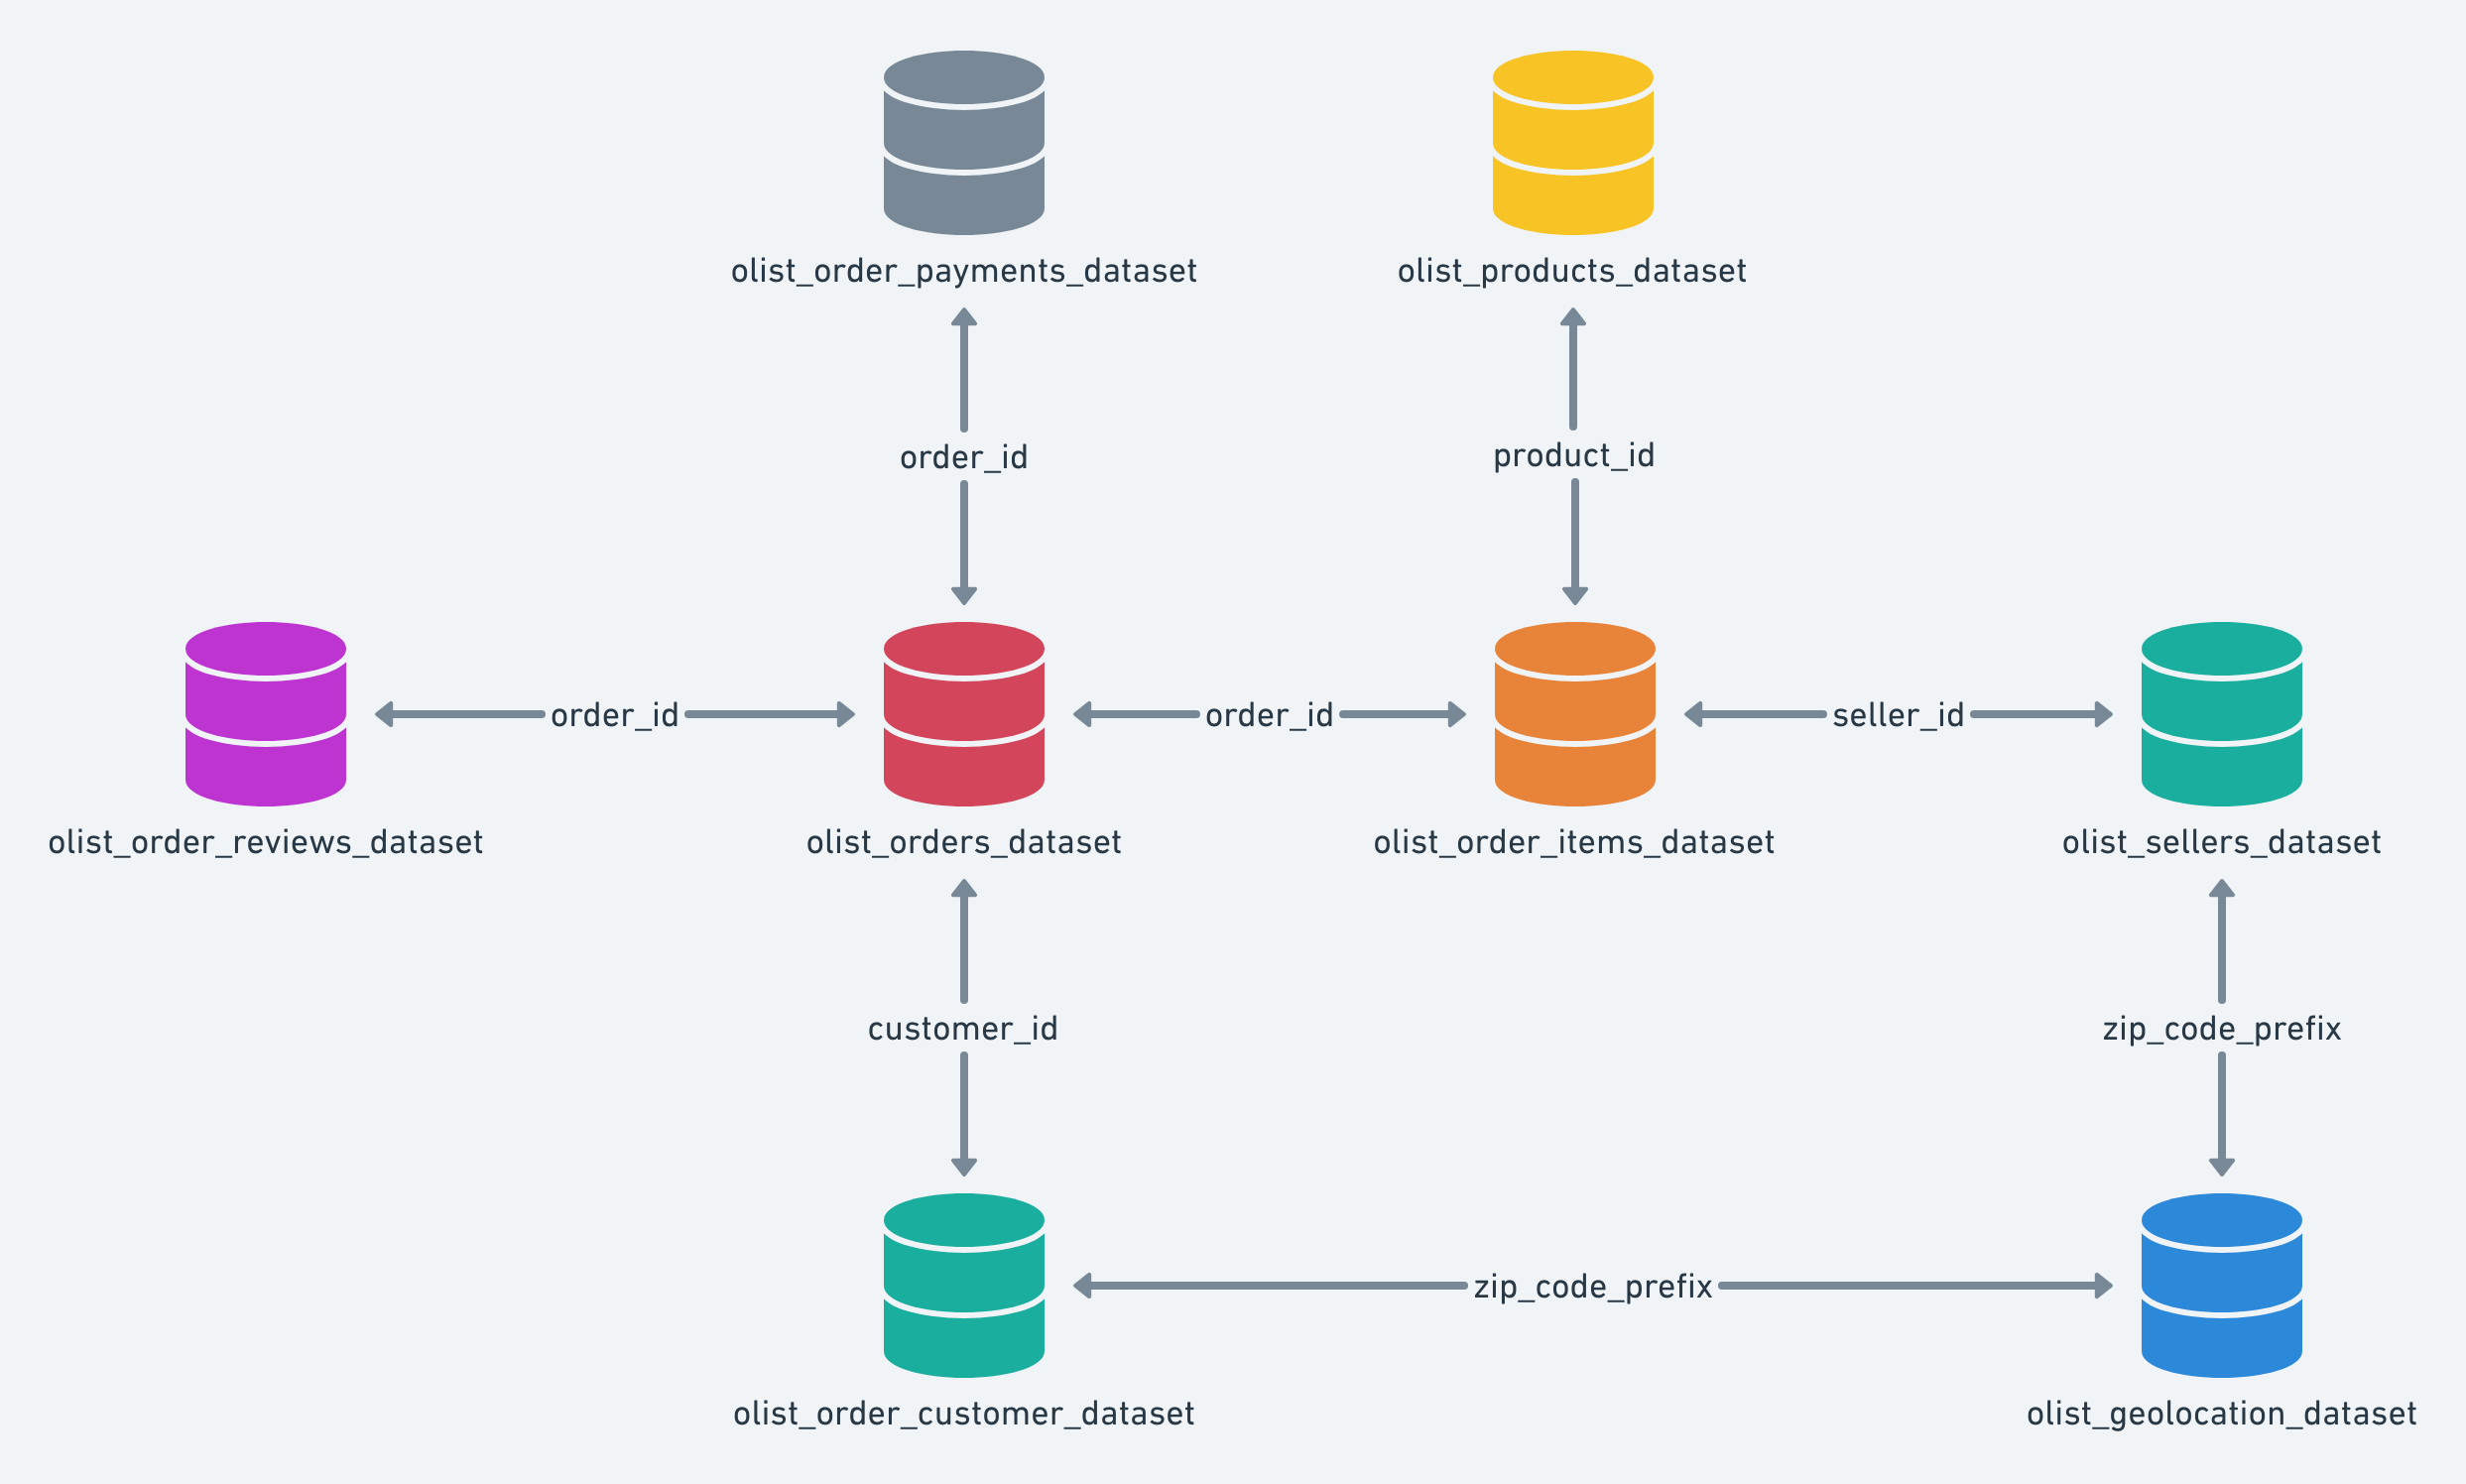

In [25]:
Image("img/MER.png")

## Lista de queries

> #### 1. Total de estados registrados.

>#### 2. Quantidade de cidades por estado.

>#### 3. Total de produtos cadastrados.

>#### 4. Número de pedidos por estado.

>#### 5. Top 10 cidades com mais pedidos em Minas Gerais e São Paulo.

>#### 6. Categorias de produto que mais venderam em Minas Gerais e São Paulo.

>#### 7. Quantidade de vendedores por estado.

>#### 8. Quantidade de pedidos por status de pedido.

>#### 9. Quantidade de pedidos entregues e quantidade de pedidos cancelados.

>#### 10.Quantidade de pedidos por tipo de pagamento.

>#### 11. Preço máximo, mínimo e médio dos valores de pedidos feitos com cartão de crédito.

>#### 12. Média do frete por categoria do produto.

>#### 13. Total de pedidos cadastrados.

>#### 14. Distribuição de reviews dos pedidos.

>#### 15. Ano em que mais enviou produtos.

>#### 16. Análise dos comentários dos pedidos.

## Queries com SQL

In [26]:
sns.set_style('whitegrid',{'grid.color': '.7','grid.linestyle': ':'})

### 1. Total de estados registrados

In [27]:
query = """

        SELECT COUNT(DISTINCT(geolocation_state)) AS estados_registrados
        
        FROM olist_geolocation;

        """

geolocation_state = pd.read_sql(query, con=conn)
geolocation_state

,estados_registrados
0,27


### 2. Quantidade de cidades por estado

In [28]:
query = """

        SELECT COUNT(DISTINCT geolocation_city) AS cidades_registradas, geolocation_state AS estados_registrados
        
        FROM olist_geolocation 
        
        GROUP BY geolocation_state 
        
        ORDER BY COUNT(DISTINCT geolocation_city) DESC;

        """

geolocation_city = pd.read_sql(query, con=conn)
geolocation_city

,cidades_registradas,estados_registrados
0,1091,MG
1,760,SP
2,524,RS
3,477,BA
4,470,PR
5,313,SC
6,257,GO
7,222,MA
8,212,CE
9,210,PE


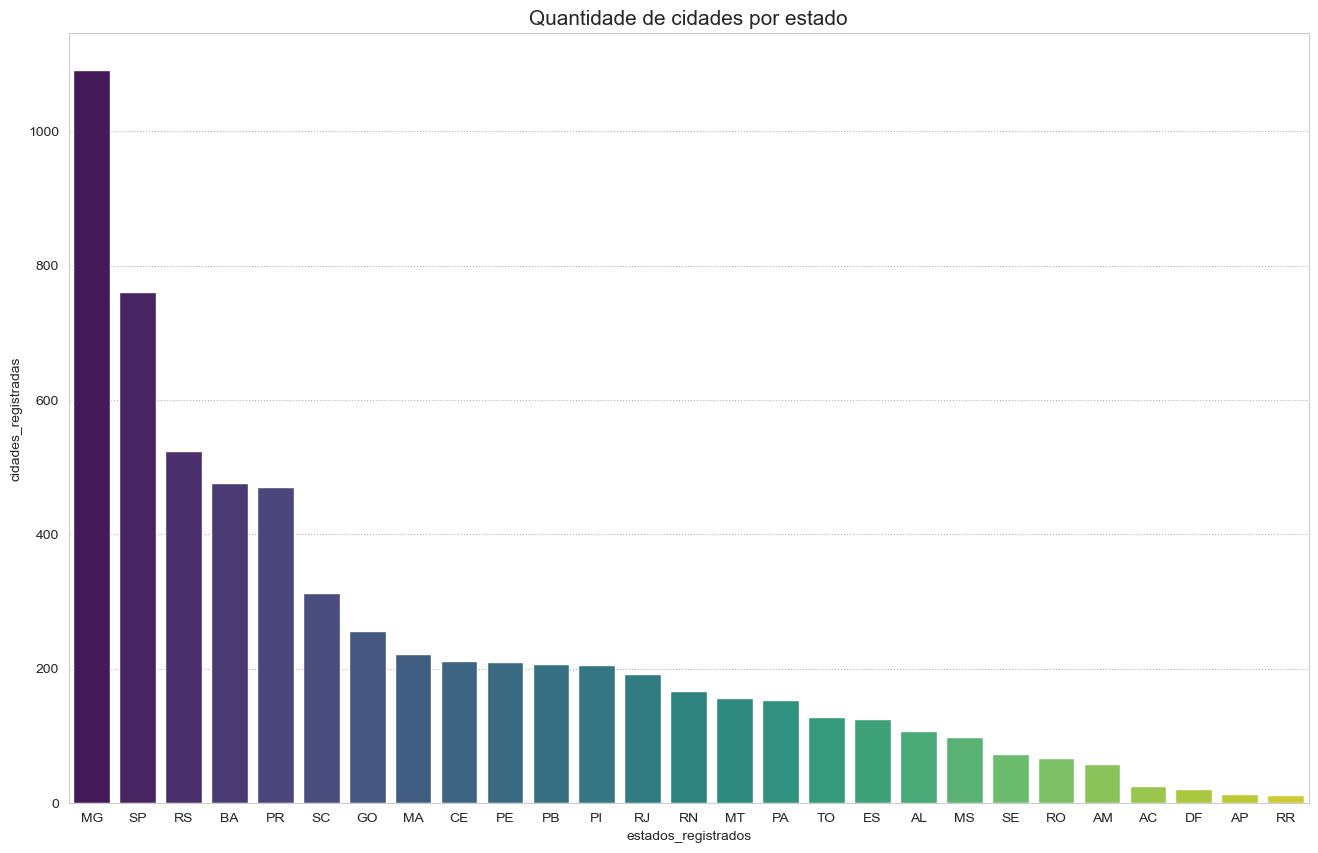

In [29]:
plt.figure(figsize=(16, 10))
plt.title('Quantidade de cidades por estado', fontsize=15)
plt.rcParams.update({'font.size': 12})

sns.barplot(x='estados_registrados', y='cidades_registradas',data=geolocation_city, palette='viridis')
plt.show()

### 3. Total de produtos cadastrados

In [30]:
query = """

        SELECT COUNT(DISTINCT(product_id)) AS total_produtos
        
        FROM olist_products;

        """

products = pd.read_sql(query, con=conn)
products

,total_produtos
0,32951


### 4. Número de pedidos por estado

In [31]:
query = """
        SELECT g.geolocation_state AS estados, COUNT(DISTINCT o.order_id) AS num_pedidos

        FROM olist_orders o
        INNER JOIN olist_order_items oi ON o.order_id = oi.order_id
        INNER JOIN olist_sellers s ON oi.seller_id = s.seller_id
        INNER JOIN olist_geolocation g ON s.seller_zip_code_prefix = g.geolocation_zip_code_prefix

        GROUP BY g.geolocation_state

        ORDER BY num_pedidos DESC;
        """

order_states = pd.read_sql(query, con=conn)
order_states

,estados,num_pedidos
0,SP,69493
1,MG,8045
2,PR,7773
3,RJ,4497
4,SC,3831
5,RS,1993
6,DF,789
7,BA,572
8,GO,463
9,PE,406


In [76]:
geo_uf = gpd.read_file('geospatial/BR_UF_2021.shp')
geo_states = geo_uf.merge(order_states, left_on='SIGLA', right_on='estados', how= 'left').fillna(0)

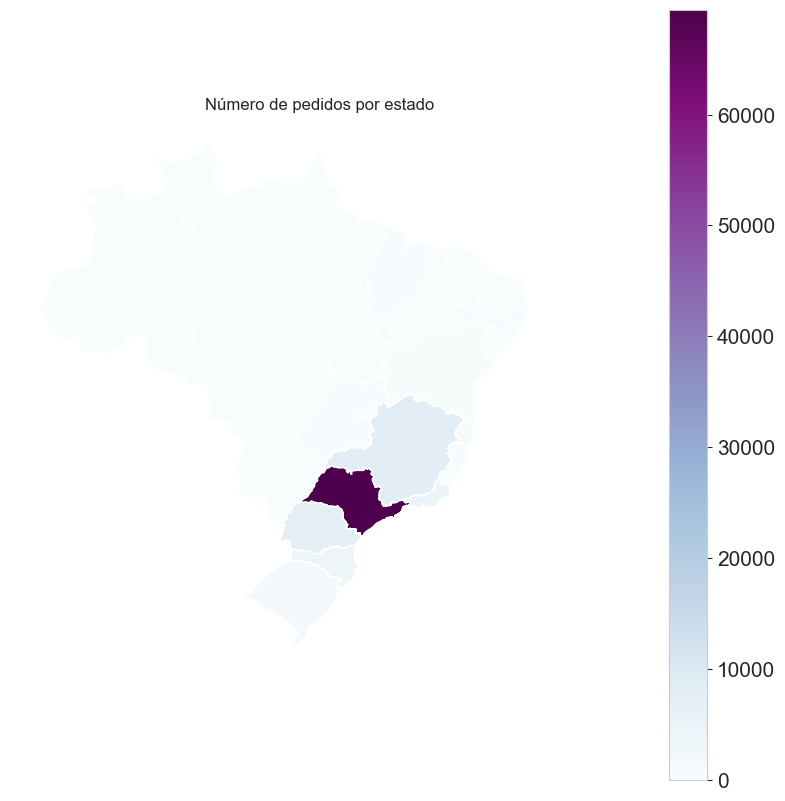

In [80]:
fig, ax = plt.subplots(figsize=(10, 10))
geo_states.plot(column='num_pedidos', cmap='BuPu', ax=ax, legend=True)
plt.title('Número de pedidos por estado', fontsize=12)
plt.axis('off')
plt.show()

### 5. Top 10 cidades com mais pedidos em MG e SP

In [34]:
query = """
        SELECT g.geolocation_city AS cidades, COUNT(DISTINCT o.order_id) AS num_pedidos

        FROM olist_orders o
        INNER JOIN olist_order_items oi ON o.order_id = oi.order_id
        INNER JOIN olist_sellers s ON oi.seller_id = s.seller_id
        INNER JOIN olist_geolocation g ON s.seller_zip_code_prefix = g.geolocation_zip_code_prefix
        
        WHERE g.geolocation_state = 'MG'

        GROUP BY g.geolocation_city

        ORDER BY num_pedidos DESC;
        
        """

order_cities_mg = pd.read_sql(query, con=conn)
order_cities_mg.head(10)

,cidades,num_pedidos
0,belo horizonte,2426
1,ilicinea,718
2,araguari,477
3,borda da mata,471
4,uberlandia,355
5,betim,271
6,monte siao,247
7,sete lagoas,246
8,tres coracoes,222
9,uba,203


In [35]:
top10mg = order_cities_mg.loc[:9].sort_values('num_pedidos', ascending=True)

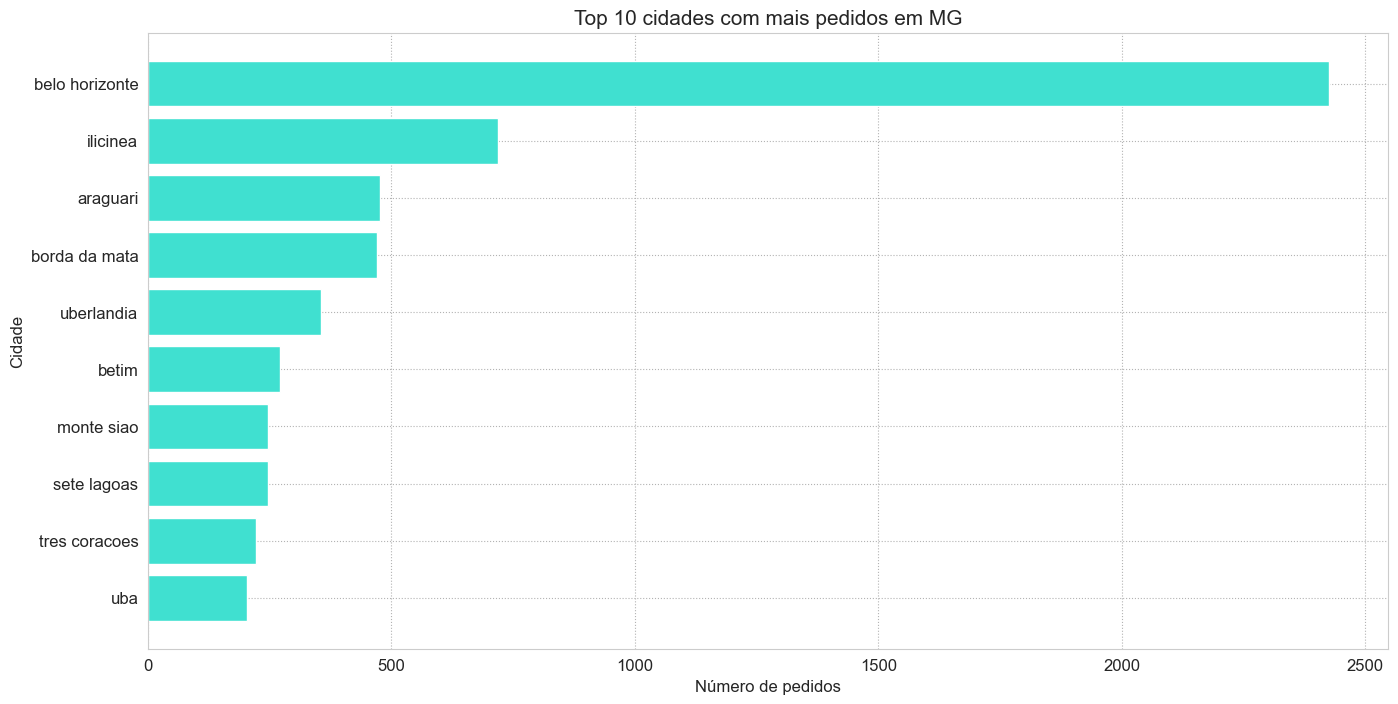

In [36]:
plt.figure(figsize=(16, 8))
plt.grid(ls=":")
plt.rcParams.update({'font.size': 12})
plt.barh(top10mg['cidades'], top10mg['num_pedidos'], color='turquoise')
plt.xlabel('Número de pedidos')
plt.ylabel('Cidade')
plt.title('Top 10 cidades com mais pedidos em MG', fontsize=15)
plt.show()

In [37]:
query = """
        SELECT g.geolocation_city AS cidades, COUNT(DISTINCT o.order_id) AS num_pedidos

        FROM olist_orders o
        INNER JOIN olist_order_items oi ON o.order_id = oi.order_id
        INNER JOIN olist_sellers s ON oi.seller_id = s.seller_id
        INNER JOIN olist_geolocation g ON s.seller_zip_code_prefix = g.geolocation_zip_code_prefix
        
        WHERE g.geolocation_state = 'SP'

        GROUP BY g.geolocation_city

        ORDER BY num_pedidos DESC;
        
        """

order_cities_sp = pd.read_sql(query, con=conn)
order_cities_sp.head(10)

,cidades,num_pedidos
0,sao paulo,24758
1,ibitinga,6565
2,santo andre,2737
3,ribeirao preto,2317
4,guarulhos,2088
5,sao jose do rio preto,2052
6,piracicaba,1633
7,campinas,1294
8,itaquaquecetuba,1241
9,praia grande,1235


In [38]:
top10sp = order_cities_sp.loc[:9].sort_values('num_pedidos', ascending=True)

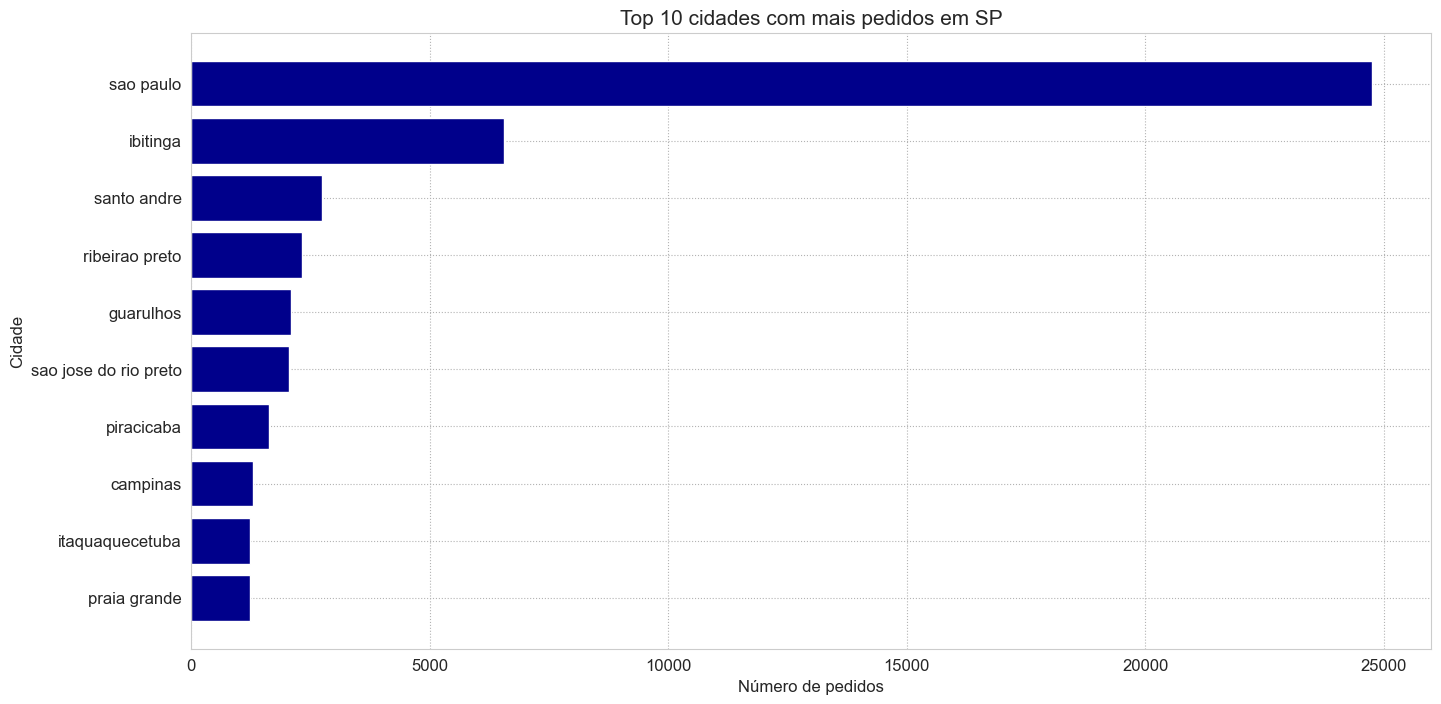

In [39]:
plt.figure(figsize=(16, 8))
plt.grid(ls=":")
plt.rcParams.update({'font.size': 12})
plt.barh(top10sp['cidades'], top10sp['num_pedidos'], color='darkblue')
plt.xlabel('Número de pedidos')
plt.ylabel('Cidade')
plt.title('Top 10 cidades com mais pedidos em SP', fontsize=15)
plt.show()

### 6. Categorias de produto que mais venderam em  Minas Gerais e  São Paulo

In [40]:
query = """
        SELECT p.product_category_name, COUNT(p.product_category_name) AS qtd_produtos

        FROM olist_products p
        INNER JOIN olist_order_items oi ON p.product_id = oi.product_id
        INNER JOIN olist_sellers s ON oi.seller_id = s.seller_id
        INNER JOIN olist_geolocation g ON s.seller_zip_code_prefix = g.geolocation_zip_code_prefix
        
        WHERE g.geolocation_state = 'MG'

        GROUP BY product_category_name

        ORDER BY qtd_produtos DESC
        
        """

product_state_mg = pd.read_sql(query, con=conn)

> Criando uma coluna de porcentagem.

In [41]:
product_state_mg['porcentagem_produtos'] = np.round(product_state_mg['qtd_produtos'] / product_state_mg['qtd_produtos'].sum() * 100,2)

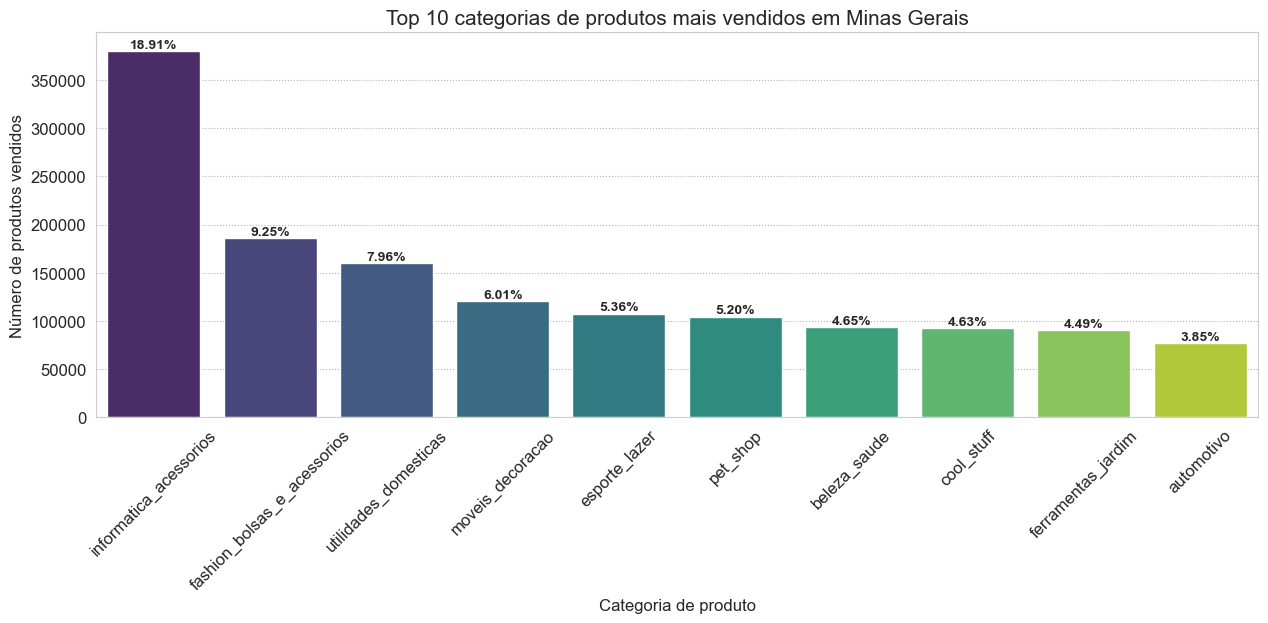

In [42]:
plt.figure(figsize=(15,5))
plt.rcParams.update({'font.size': 12})
ax = sns.barplot(x='product_category_name', y='qtd_produtos', data=product_state_mg.loc[:9], palette='viridis')
plt.title('Top 10 categorias de produtos mais vendidos em Minas Gerais', fontsize=15)
plt.xlabel('Categoria de produto')
plt.ylabel('Número de produtos vendidos')
plt.xticks(rotation=45)

total_products = product_state_mg["qtd_produtos"].sum()
for i, container in enumerate(ax.containers):
    for j, bar in enumerate(container):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, 
                height+1, 
                f"{height/total_products*100:.2f}%", 
                ha='center', 
                va='bottom', 
                fontsize=10, 
                fontweight='bold')

plt.show()

In [43]:
query = """
        SELECT p.product_category_name, COUNT(p.product_category_name) AS qtd_produtos

        FROM olist_products p
        INNER JOIN olist_order_items oi ON p.product_id = oi.product_id
        INNER JOIN olist_sellers s ON oi.seller_id = s.seller_id
        INNER JOIN olist_geolocation g ON s.seller_zip_code_prefix = g.geolocation_zip_code_prefix
        
        WHERE g.geolocation_state = 'SP'

        GROUP BY product_category_name

        ORDER BY qtd_produtos DESC
        
        """

product_state_sp = pd.read_sql(query, con=conn)

> Criando uma coluna de porcentagem.

In [44]:
product_state_sp['porcentagem_produtos'] = np.round(product_state_sp['qtd_produtos'] / product_state_sp['qtd_produtos'].sum() * 100,2)

product_state_sp

,product_category_name,qtd_produtos,porcentagem_produtos
0,cama_mesa_banho,2182811,20.52
1,beleza_saude,872784,8.20
2,moveis_decoracao,794704,7.47
3,utilidades_domesticas,726950,6.83
4,ferramentas_jardim,685010,6.44
...,...,...,...
69,pc_gamer,1167,0.01
70,la_cuisine,429,0.00
71,seguros_e_servicos,258,0.00
72,fashion_roupa_infanto_juvenil,252,0.00


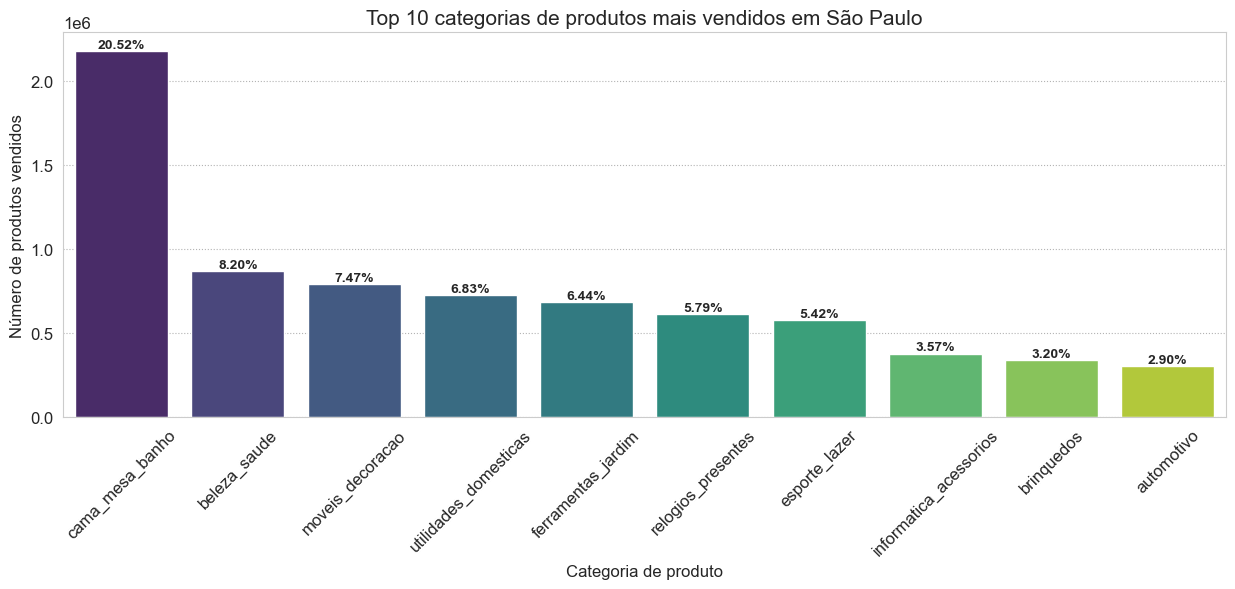

In [45]:
plt.figure(figsize=(15,5))
plt.rcParams.update({'font.size': 12})
ax = sns.barplot(x="product_category_name", y="qtd_produtos", palette='viridis', data=product_state_sp.loc[:9])
plt.title("Top 10 categorias de produtos mais vendidos em São Paulo", fontsize=15)
plt.xlabel("Categoria de produto")
plt.ylabel("Número de produtos vendidos")
plt.xticks(rotation=45)

total_products = product_state_sp["qtd_produtos"].sum()
for i, container in enumerate(ax.containers):
    for j, bar in enumerate(container):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, 
                height+1, 
                f"{height/total_products*100:.2f}%", 
                ha='center', 
                va='bottom', 
                fontsize=10, 
                fontweight='bold')

plt.show()

### 7. Quantidade de vendedores por estado

In [46]:
query = """
        SELECT seller_state AS estados, COUNT(DISTINCT seller_zip_code_prefix) AS qtd_vendedores

        FROM olist_sellers

        GROUP BY seller_state

        ORDER BY qtd_vendedores DESC

        """

seller_state = pd.read_sql(query, con=conn)
seller_state.head(20)

,estados,qtd_vendedores
0,SP,1333
1,PR,219
2,MG,180
3,RJ,138
4,SC,134
5,RS,105
6,GO,35
7,DF,29
8,ES,23
9,BA,17


In [47]:
seller_state['qtd_vendedores'] = np.log1p(seller_state['qtd_vendedores'])

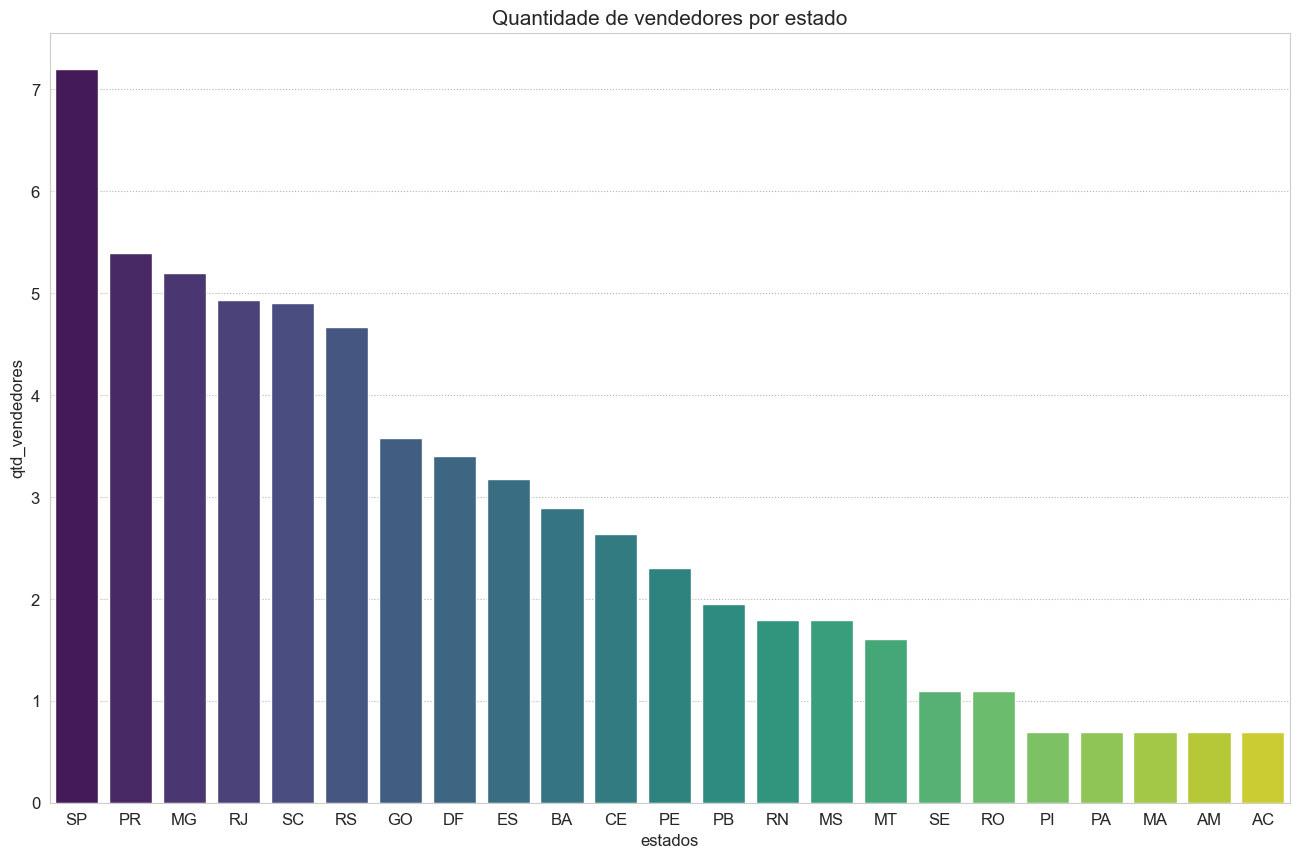

In [48]:
plt.figure(figsize=(16, 10))
plt.title('Quantidade de vendedores por estado', fontsize=15)
plt.rcParams.update({'font.size': 15})
sns.barplot(x='estados', y='qtd_vendedores', data=seller_state, palette='viridis')
plt.show()

### 8. Quantidade de pedidos por status de pedido

In [49]:
query = """
        SELECT order_status AS status_pedidos, COUNT(DISTINCT customer_id) AS qtd_clientes

        FROM olist_orders

        GROUP BY order_status

        ORDER BY qtd_clientes DESC
        
        """

order_status = pd.read_sql(query, con=conn)
order_status

,status_pedidos,qtd_clientes
0,delivered,96478
1,shipped,1107
2,canceled,625
3,unavailable,609
4,invoiced,314
5,processing,301
6,created,5
7,approved,2


### 9. Quantidade de pedidos entregues e quantidade de pedidos cancelados

In [50]:
query = """
        SELECT order_status AS status_pedidos, COUNT(DISTINCT customer_id) AS qtd_clientes

        FROM olist_orders

        WHERE order_status IN ('delivered','canceled')
        
        GROUP BY order_status

        ORDER BY qtd_clientes DESC
        
        """

order_status = pd.read_sql(query, con=conn)
order_status

,status_pedidos,qtd_clientes
0,delivered,96478
1,canceled,625


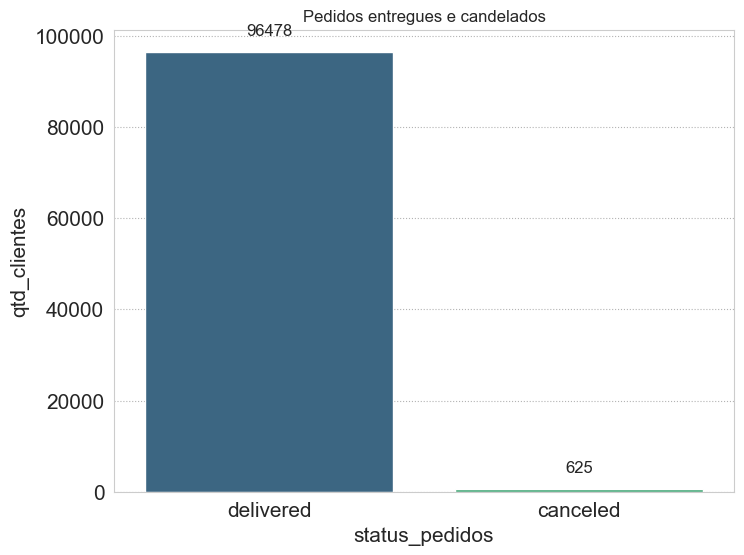

In [51]:
plt.figure(figsize=(8, 6))
plt.title('Pedidos entregues e candelados', fontsize=12)
plt.rcParams.update({'font.size': 12})

ax = sns.barplot(x='status_pedidos', y='qtd_clientes', palette= 'viridis', data=order_status)

for i in ax.containers:
    ax.bar_label(i, label_type="edge", padding=10)

plt.show()

### 10.Quantidade de pedidos por tipo de pagamento

In [52]:
query = """
        SELECT COUNT(payment_sequential) AS qtd_pedidos, payment_type AS tipos_pagamentos
        
        FROM olist_order_payments
        
        GROUP BY payment_type
        
        ORDER BY qtd_pedidos DESC
        
        """

order_payments = pd.read_sql(query, con=conn)
order_payments

,qtd_pedidos,tipos_pagamentos
0,76795,credit_card
1,19784,boleto
2,5775,voucher
3,1529,debit_card
4,3,not_defined


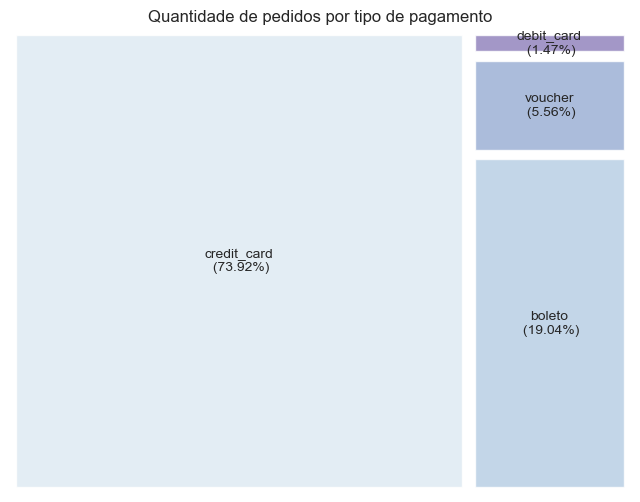

In [53]:
# Ordenando os dados pelo número de pedidos em ordem decrescente
order_payments = order_payments.sort_values(by='qtd_pedidos', ascending=False)

# Removendo a linha "not_defined"

order_payments2 = order_payments[order_payments['tipos_pagamentos'] != 'not_defined']

# Preparando os dados para o treemap

sizes = order_payments2['qtd_pedidos']
perc = 100 * sizes / sizes.sum()
labels = [f"{i[0]}\n ({i[1]:.2f}%)" for i in zip(order_payments2['tipos_pagamentos'], perc.values)]

# Criando um treemap
plt.figure(figsize=(8, 6))
plt.title('Quantidade de pedidos por tipo de pagamento', fontsize=12)
plt.axis('off')

# Usando o método squarify para criar o treemap
squarify.plot(pad=1, sizes=sizes,alpha=0.8, label=labels, text_kwargs={'fontsize':10}, color= sns.color_palette("BuPu"))

plt.show()


### 11. Preço máximo, mínimo e médio dos valores de pedidos feitos com cartão de crédito

In [54]:
query = """
        SELECT MAX(payment_value) AS valor_maximo, ROUND(MIN(payment_value),2) AS valor_minimo, ROUND(AVG(payment_value),2) AS valor_medio
        FROM olist_order_payments
        WHERE payment_type == 'credit_card'
        """

order_values = pd.read_sql(query, con=conn)
order_values

,valor_maximo,valor_minimo,valor_medio
0,13664.08,0.01,163.32


### 12. Média do frete por categoria do produto

In [55]:
query = """
        SELECT p.product_category_name AS categoria_produto, ROUND(AVG(oi.freight_value),2) AS media_frete

        FROM olist_products p INNER JOIN olist_order_items oi ON p.product_id = oi.product_id

        GROUP BY p.product_category_name

        ORDER BY oi.freight_value DESC
        
        """

order_freight = pd.read_sql(query, con=conn)
order_freight = order_freight.sort_values(by= 'media_frete', ascending = False)
order_freight.head(15)

,categoria_produto,media_frete
0,pcs,48.45
23,eletrodomesticos_2,44.54
8,moveis_colchao_e_estofado,42.91
57,moveis_cozinha_area_de_servico_jantar_e_jardim,42.70
13,moveis_quarto,42.50
5,moveis_escritorio,40.55
2,portateis_casa_forno_e_cafe,36.16
4,moveis_sala,35.72
32,sinalizacao_e_seguranca,32.70
11,industria_comercio_e_negocios,29.42


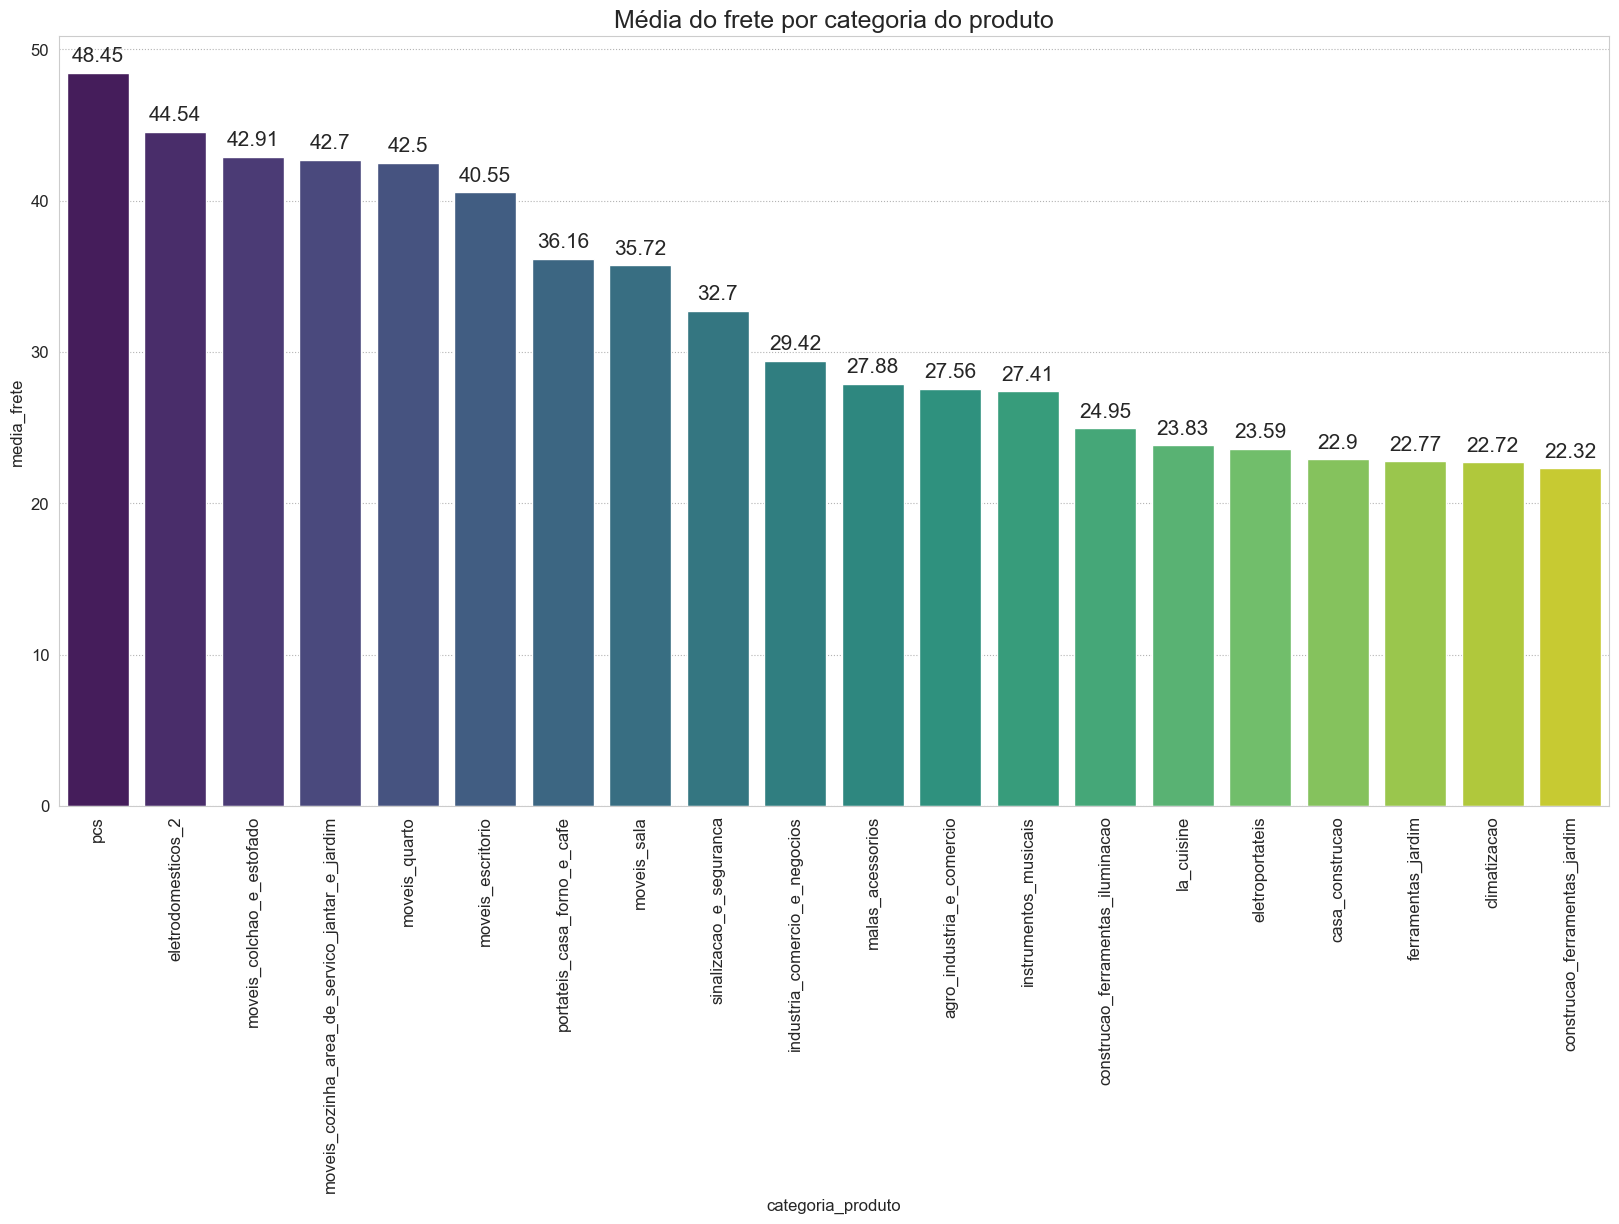

In [56]:
plt.figure(figsize=(20, 10))
plt.title('Média do frete por categoria do produto', fontsize=18)
plt.rcParams.update({'font.size': 15})

ax = sns.barplot(x='categoria_produto', y='media_frete', palette= 'viridis', data=order_freight.loc[:10])

plt.xticks(rotation=90)

for i in ax.containers:
    ax.bar_label(i, label_type="edge", padding=5)
    
plt.show()

### 13. Total de pedidos cadastrados 

In [57]:
query = """
        SELECT COUNT(DISTINCT customer_id) AS total_pedidos

        FROM olist_orders
        
        """

orders = pd.read_sql(query, con=conn)
orders

,total_pedidos
0,99441


### 14. Distribuição de reviews dos pedidos

In [58]:
query = """
        SELECT review_score, COUNT(order_id) AS reviews_clientes

        FROM olist_order_reviews

        GROUP BY review_score

        ORDER BY reviews_clientes DESC
        
        """

order_reviews = pd.read_sql(query, con=conn)
order_reviews

,review_score,reviews_clientes
0,5,57328
1,4,19142
2,1,11424
3,3,8179
4,2,3151


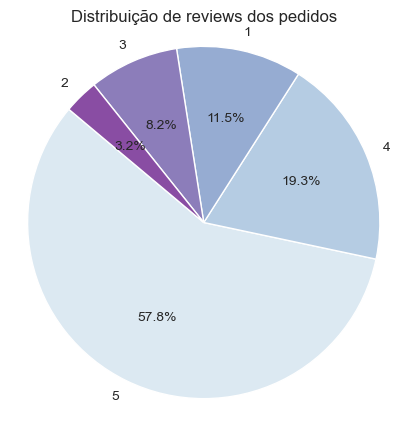

In [59]:
order_reviews = order_reviews.sort_values(by='reviews_clientes', ascending=False)

labels = order_reviews['review_score']
sizes = order_reviews['reviews_clientes']

plt.figure(figsize=(5, 5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors= sns.color_palette("BuPu"), textprops={'fontsize': 10})

plt.axis('equal')

plt.title('Distribuição de reviews dos pedidos', fontsize=12)

plt.show()

### 15. Ano em que mais enviou produtos

In [60]:
query = """
        SELECT strftime('%Y', shipping_limit_date) AS ano_envio, COUNT(DISTINCT product_id) AS qtd_produtos
        FROM olist_order_items
        GROUP BY strftime('%Y', shipping_limit_date)
        ORDER BY qtd_produtos DESC
        LIMIT 1000;
        """

order_year = pd.read_sql(query, con=conn)
order_year

,ano_envio,qtd_produtos
0,2018,20747
1,2017,17003
2,2016,277
3,2020,3


In [61]:
order_year = order_year.sort_values(by= 'ano_envio', ascending=True)

<Axes: title={'center': 'Quantidade de produtos enviados por ano'}, xlabel='ano_envio', ylabel='qtd_produtos'>

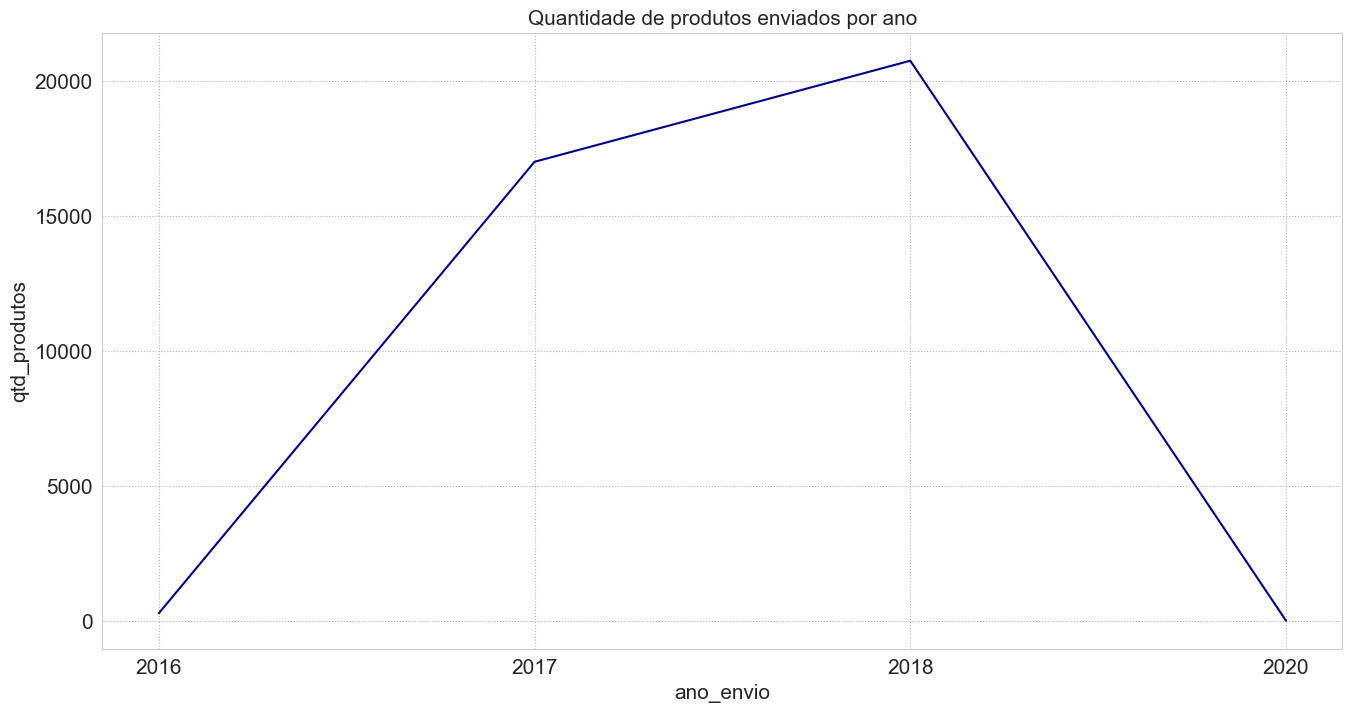

In [62]:
plt.figure(figsize=(16, 8))
plt.title('Quantidade de produtos enviados por ano', fontsize=15)
plt.rcParams.update({'font.size': 15})
sns.lineplot(data=order_year, x='ano_envio', y='qtd_produtos', color='darkblue')

In [63]:
olist_order_items['shipping_limit_date'].max()

'2020-04-09 22:35:08'

OBS: os registros do ano de 2020 são até abril, por esse motivo, não é possível afirmar que houve diminuição pedidos de 2018 a 2020. No entanto, de acordo com os dados presentes, o maior ano de vendas foi o de 2018.

## 16. Análise dos comentários dos pedidos

In [64]:
filtered_reviews = olist_order_reviews.loc[~pd.isnull(olist_order_reviews['review_comment_message'])]

In [65]:
text = filtered_reviews['review_comment_message']

text = filtered_reviews['review_comment_message'].str.cat(sep=' ')

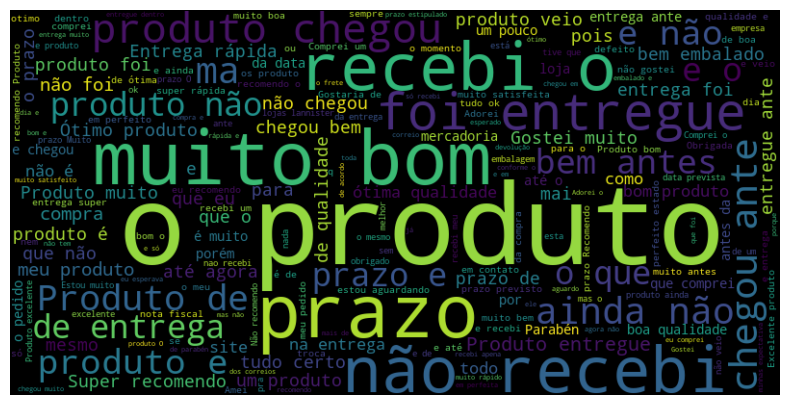

In [66]:
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(text)

plt.figure(figsize=(15, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Fechando a conexão com o banco de dados

In [67]:
conn.close()